In [192]:
## Import Packages
import numpy as np  
import matplotlib.pyplot as plt
import functions as f
import seaborn as sns
import scipy.stats as sts
from scipy.optimize import fsolve
import pandas

# Chapter 2: Credit Risk Management

## Dependent Default Structure

In [193]:
nr_of_sims = 1
port_size = 100
lgd = np.ones(port_size)
ntnls = np.ones(port_size)
pd = 0.5
pds = np.ones(port_size)*pd
cor = 0.4

s, i, av = f.sim_av_gauss(cor, port_size, nr_of_sims)

av = np.squeeze(av)
s = np.squeeze(s)
i = np.squeeze(i)

s_data = [np.linspace(0,cor,1000), np.linspace(0, s, 1000)]
i_data = [[np.linspace(cor, 1, 1000), np.linspace(s, s + i[k])] for k in range(port_size)]

defaults = av < sts.norm.ppf(pds)

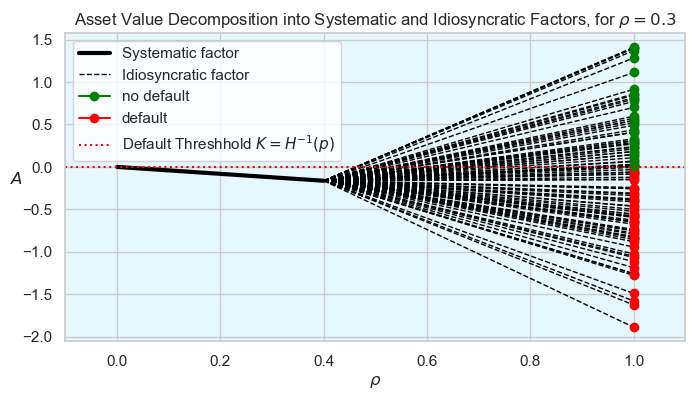

In [194]:
# Create a Seaborn plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
plt.subplot()
sns.lineplot(x=s_data[0], y=s_data[1], color="black", linewidth = 3, label = "Systematic factor")
def_flag = False
non_def_flag = False
for k in range(port_size):
    x_data = np.linspace(cor, 1, 1000)
    y_data = np.linspace(s, s+i[k], 1000)
     
    if k == 0:
        sns.lineplot(x=x_data, y=y_data, color = "black", linewidth = 1, label = "Idiosyncratic factor", linestyle = "dashed")
    else:
        sns.lineplot(x=x_data, y=y_data, color = "black", linewidth = 1, linestyle = "dashed")
    if defaults[k]:
        if not def_flag:
            plt.plot(1,av[k], marker = "o", color = "red", label ="default")
            def_flag = True
        else:
            plt.plot(1,av[k], marker = "o", color = "red")
    else:
        if not non_def_flag:
            plt.plot(1,av[k], marker = "o", color = "green", label ="no default")
            non_def_flag = True
        else:
            plt.plot(1,av[k], marker = "o", color = "green")
        
plt.axhline(sts.norm.ppf(pd), linestyle = "dotted", color = "red", label = "Default Threshhold $K = H^{-1}(p)$")
plt.title(r"Asset Value Decomposition into Systematic and Idiosyncratic Factors, for $\rho = 0.3$")
plt.xlim(-0.1,1.1)
plt.xlabel(r'$\rho$')
plt.ylabel('$A$', rotation=0)
plt.legend()

## Large Homogenous Portfolio Approximation

In [195]:
#  Setup paramaters for three different Gaussian Loss PDFs
nr_of_sims = 100000
port_size = 1000
exp_weights = np.ones(port_size)/port_size
pd = 0.3
pds = np.ones(port_size)*pd
cor1 = 0.1
cor2 = 0.7
s1, i, av1 = f.sim_av_gauss(cor1, port_size, nr_of_sims)
s2, i, av2 = f.sim_av_gauss(cor2, port_size, nr_of_sims)
losses1 = f.calc_losses_norm(av1, pd, exp_weights)
losses2 = f.calc_losses_norm(av2, pd, exp_weights)
lhp_losses1 = np.squeeze(f.cond_pd_norm(s1, pd, cor1))
lhp_losses2 = np.squeeze(f.cond_pd_norm(s2, pd, cor2))

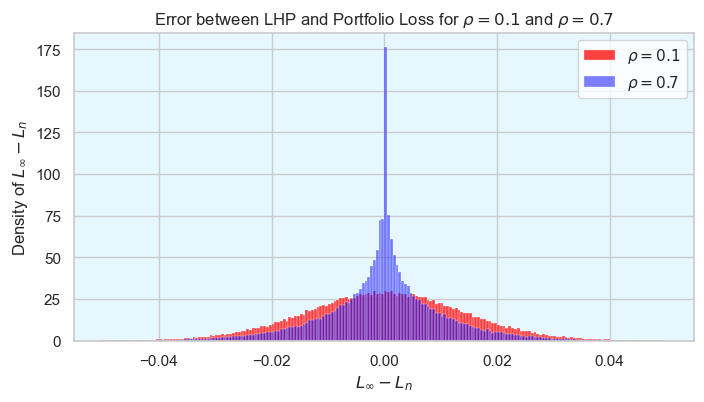

In [196]:
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
ax = sns.histplot(data=lhp_losses1-losses1, label=r"$\rho=0.1$", color="red", bins=200, binrange=(-0.05, 0.05), stat="density")
sns.histplot(data=lhp_losses2-losses2, label=r"$\rho=0.7$", color="blue", bins=200, binrange=(-0.05, 0.05),stat="density", alpha=0.5)
# Set labels and title
plt.xlabel("$L_{\infty} - L_n$")
plt.ylabel("Density of $L_{\infty} - L_n$")
plt.title(r"Error between LHP and Portfolio Loss for $\rho=0.1$ and $\rho=0.7$")

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Chapter 3 : CDO Pricing Models

## Tranching Transformation

Text(0.5, 1.0, 'Plot of the Tranching Transformation')

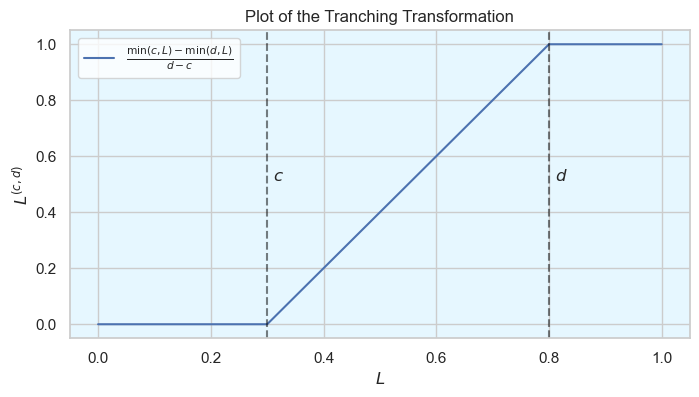

In [197]:
c = 0.3
d = 0.8
losses = np.linspace(0, 1, 1000)
tranche_losses = f.calc_tranche_losses(losses,c, d)
plot_data = pandas.DataFrame(tranche_losses, losses)

# Create a Seaborn plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
sns.lineplot(x=losses, y=tranche_losses, label=r"$\frac{\min(c,L) - \min(d,L)}{d-c}$")
plt.axvline(c, linestyle = "dashed", color = "black", alpha = 0.5)
plt.text(c+0.01, 0.5, '$c$', rotation=0, verticalalignment='bottom')
plt.axvline(d, linestyle = "dashed", color = "black", alpha = 0.5)
plt.text(d+0.01, 0.5, '$d$', rotation=0, verticalalignment='bottom')
plt.xlabel('$L$')
plt.ylabel('$L^{(c,d)}$')
plt.title("Plot of the Tranching Transformation")

## Conditional Expectation Convergence

In [198]:
pd = 0.1
cor = 0.3
c = 0.4
d = 1
tranche_losses = []
lhp_tranche_losses = []
cond_exp_losses = []
mse = []
corr_lhp_tranche = []
corr_cond_exp = []
for p_size in range(10, 1000, 1):
    nr_of_sims=1000
    exp_weights = np.ones(p_size)/p_size
    pds = np.ones(p_size)*pd
    s, i, av = f.sim_av_gauss(cor, p_size, nr_of_sims)
    loss = f.calc_losses_norm(av, pd, exp_weights)
    tranche_loss = f.calc_tranche_losses(loss, c, d)
    lhp_loss = f.cond_pd_norm(s, pd, cor)
    lhp_tranche_loss = f.calc_tranche_losses(lhp_loss, c, d)
    cond_pd = np.squeeze(f.cond_pd_norm(s, pd, cor))

    binom_p = np.mat(cond_pd)
    binom_n = p_size
    eval_points = np.mat(np.arange(binom_n+1)).T
    pmfs = sts.binom.pmf(eval_points, binom_n, binom_p)
    pmfs_tranche = pmfs[:int(np.floor(binom_n*c))+1, :]
    eval_points_tranche = np.tile(eval_points, (1, nr_of_sims))[:int(np.floor(binom_n*c))+1, :]
    cond_exp_part1 = np.sum(np.multiply(pmfs_tranche,eval_points_tranche), axis=0)
    cond_exp_part2 = c * np.sum(pmfs[int(np.floor(binom_n*c))+1:, :], axis = 0)
    cond_exp = cond_exp_part1 /binom_n + cond_exp_part2
    cond_exp_c = np.squeeze(np.array(cond_exp))

    binom_p = np.mat(cond_pd)
    binom_n = port_size
    eval_points = np.mat(np.arange(binom_n+1)).T
    pmfs = sts.binom.pmf(eval_points, binom_n, binom_p)
    pmfs_tranche = pmfs[:int(np.floor(binom_n*d))+1, :]
    eval_points_tranche = np.tile(eval_points, (1, nr_of_sims))[:int(np.floor(binom_n*d))+1, :]
    cond_exp_part1 = np.sum(np.multiply(pmfs_tranche,eval_points_tranche), axis=0)
    cond_exp_part2 = d * np.sum(pmfs[int(np.floor(binom_n*d))+1:, :], axis = 0)
    cond_exp = cond_exp_part1 /binom_n + cond_exp_part2
    cond_exp_d = np.squeeze(np.array(cond_exp))
    print(p_size)
    tranche_loss = np.squeeze(tranche_loss)
    lhp_tranche_loss = np.squeeze(lhp_tranche_loss)
    cond_exp_loss = np.squeeze((cond_exp_d - cond_exp_c)/(d-c))
    mse.append( ( (lhp_tranche_loss - cond_exp_loss)**2 ).mean() )
    corr_lhp_tranche.append(np.corrcoef(tranche_loss, lhp_tranche_loss)[0,1])
    corr_cond_exp.append(np.corrcoef(tranche_loss, cond_exp_loss)[0,1])



10
11
12
13
14
15


16
17
18
19
20
21
22
23


c:\Users\cnlve\anaconda3\envs\myhive\Lib\site-packages\scipy\stats\_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292


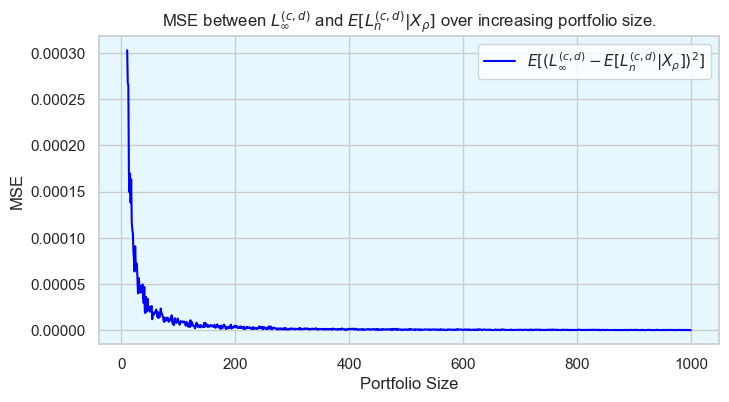

(990,)


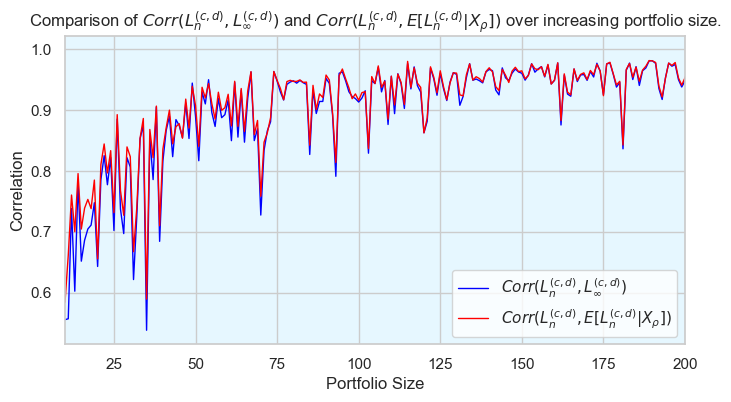

In [199]:
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
ax = sns.lineplot(x = range(10, 1000, 1), y=mse, label=r"$E[(L_{\infty}^{(c,d)} - E[L_n^{(c,d)}|X_{\rho}])^2]$", color="blue")

# Set labels and title
plt.xlabel("Portfolio Size")
plt.ylabel("MSE")
plt.title(r"MSE between $L_{\infty}^{(c,d)}$ and $E[L_n^{(c,d)}|X_{\rho}]$ over increasing portfolio size.")

# Add a legend
plt.legend()

# Show the plot
plt.show()

corr_lhp_tranche = np.array(corr_lhp_tranche)
corr_cond_exp = np.array(corr_cond_exp)

print(np.shape(corr_lhp_tranche))


sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
sns.lineplot(x = range(10, 1000, 1), y=corr_lhp_tranche, label=r"$Corr(L_n^{(c,d)}, L_{\infty}^{(c,d)})$", color="blue", linewidth = 1)
sns.lineplot(x = range(10, 1000, 1), y=corr_cond_exp, label=r"$Corr(L_n^{(c,d)}, E[L_n^{(c,d)}|X_{\rho}])$", color="red", linewidth = 1)

# Set labels and title
plt.xlabel("Portfolio Size")
plt.ylabel("Correlation")
plt.title(r"Comparison of $Corr(L_n^{(c,d)}, L_{\infty}^{(c,d)})$ and $Corr(L_n^{(c,d)},E[L_n^{(c,d)}|X_{\rho}])$ over increasing portfolio size.")
plt.xlim(10, 200)

# Add a legend
plt.legend()

# Show the plot
plt.show()


# Chapter 5: Numerical Analysis

## Gaussian Loss Density

In [200]:
#  Setup paramaters for three different Gaussian Loss PDFs
nr_of_sims = 100000
port_size = 100
exp_weights = np.ones(port_size)/port_size
pd = 0.3
pds = np.ones(port_size)*pd
cor1 = 0
cor2 = 0.2
cor3 = 0.4
s1, i, av1 = f.sim_av_gauss(cor1, port_size, nr_of_sims)
s2, i, av2 = f.sim_av_gauss(cor2, port_size, nr_of_sims)
s3, i, av3 = f.sim_av_gauss(cor3, port_size, nr_of_sims)
losses1 = f.calc_losses_norm(av1, pd, exp_weights)
losses2 = f.calc_losses_norm(av2, pd, exp_weights)
losses3 = f.calc_losses_norm(av3, pd, exp_weights)

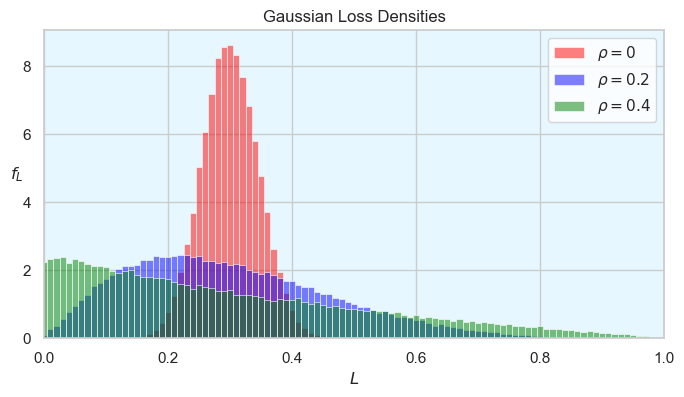

In [201]:
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
bins = np.arange(-0.005, 1.01, 0.01)  # Specify bin width
binrange = (-0.5, 1.5)
sns.histplot(data=losses1, label=r"$\rho=0$", color="red", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=losses2, label=r"$\rho=0.2$", color="blue", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=losses3, label=r"$\rho=0.4$", color="green", bins=bins, binrange=binrange, stat="density", alpha=0.5)

# Set labels and title
plt.xlabel(r"$L$")
plt.ylabel(r"$f_L$", rotation=0)
plt.xlim(0, 1)

# Add a legend
plt.legend()

plt.title("Gaussian Loss Densities")

# Show the plot
plt.show()

## Shifted Gamma Loss Density

In [202]:
#  Setup paramaters for three different Shifted Gamma Loss PDFs
nr_of_sims = 100000
port_size = 100
a = 1
exp_weights = np.ones(port_size)/port_size
pd = 0.3
pds = np.ones(port_size)*pd
cor1 = 0
cor2 = 0.2
cor3 = 0.4
s1, i, av1 = f.sim_av_shifted_gamma(a, cor1, port_size, nr_of_sims)
s2, i, av2 = f.sim_av_shifted_gamma(a, cor2, port_size, nr_of_sims)
s3, i, av3 = f.sim_av_shifted_gamma(a, cor3, port_size, nr_of_sims)
losses1 = f.calc_losses_sg(av1, a, pd, exp_weights)
losses2 = f.calc_losses_sg(av2, a, pd, exp_weights)
losses3 = f.calc_losses_sg(av3, a, pd, exp_weights)

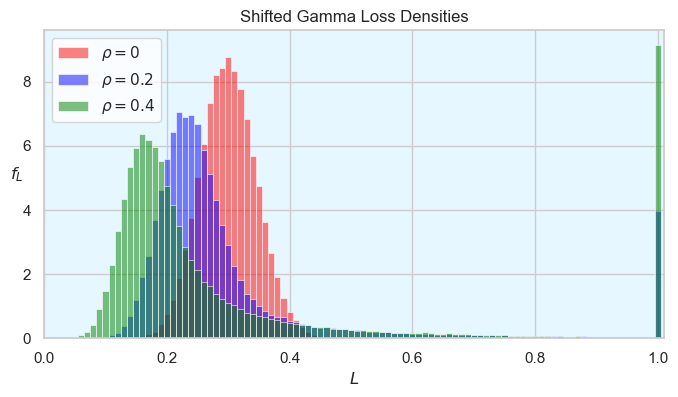

In [203]:
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
bins = np.arange(-0.005, 1.01, 0.01)  # Specify bin width
binrange = (-0.5, 1.5)
sns.histplot(data=losses1, label=r"$\rho=0$", color="red", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=losses2, label=r"$\rho=0.2$", color="blue", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=losses3, label=r"$\rho=0.4$", color="green", bins=bins, binrange=binrange, stat="density", alpha=0.5)

# Set labels and title
plt.xlabel(r"$L$")
plt.ylabel(r"$f_L$", rotation=0)
plt.xlim(0, 1.01)

# Add a legend
plt.legend()

plt.title("Shifted Gamma Loss Densities")

# Show the plot
plt.show()

## Shifted Gamma Systematic Factor Density

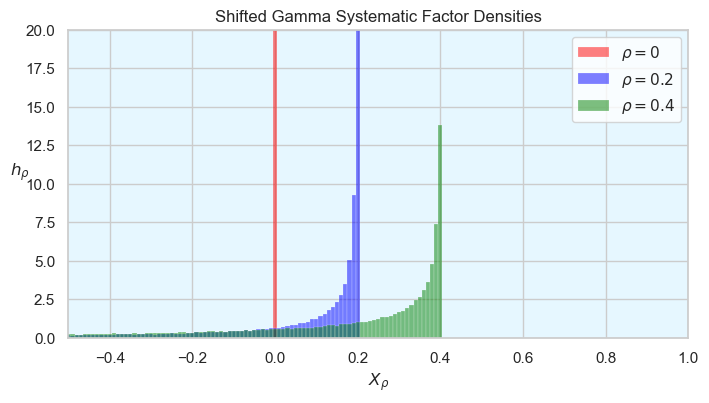

In [204]:
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
bins = np.arange(-2.005, 1.005, 0.01)  # Specify bin width
binrange = (-0.5, 1.5)
sns.histplot(data=s1[0], label=r"$\rho=0$", color="red", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=s2[0], label=r"$\rho=0.2$", color="blue", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=s3[0], label=r"$\rho=0.4$", color="green", bins=bins, binrange=binrange, stat="density", alpha=0.5)

# Set labels and title
plt.xlabel(r"$X_{\rho}$")
plt.ylabel(r"$h_{\rho}$", rotation=0)
plt.xlim(-0.5, 1)
plt.ylim(0, 20)

# Add a legend
plt.legend()

plt.title("Shifted Gamma Systematic Factor Densities")

# Show the plot
plt.show()

## Shifted Gamma Conditional PD

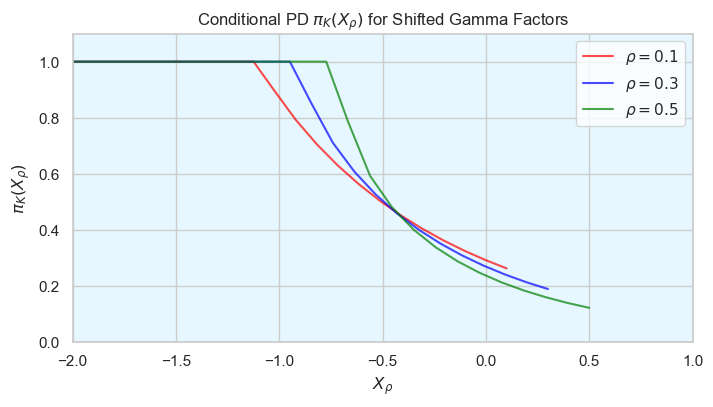

In [205]:
cor1 = 0.1
cor2 = 0.3
cor3 = 0.5
x_domain1 = np.linspace(-10, cor1, 100)
x_domain2 = np.linspace(-10, cor2, 100)
x_domain3 = np.linspace(-10, cor3, 100)
y1 = f.cond_pd_sg(x_domain1, a, pd, cor1)
y2 = f.cond_pd_sg(x_domain2, a, pd, cor2)
y3 = f.cond_pd_sg(x_domain3, a, pd, cor3)

sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x=x_domain1, y=y1, label=r"$\rho = 0.1$", color="red", alpha = 0.7)
sns.lineplot(x=x_domain2, y=y2, label=r"$\rho = 0.3$", color="blue", alpha = 0.7)
sns.lineplot(x=x_domain3, y=y3, label=r"$\rho = 0.5$", color="green", alpha = 0.7)

# Set labels and title
plt.xlabel(r"$X_{\rho}$")
plt.ylabel(r"$\pi_K(X_{\rho})$")
plt.xlim(-2, 1)
plt.ylim(0, 1.1)

# Add a legend
plt.legend()

plt.title(r"Conditional PD $\pi_K(X_{\rho})$ for Shifted Gamma Factors")

# Show the plot
plt.show()

## Homogenous Portfolio Analysis

### Parameters

In [206]:
seed = 163
nr_of_sims = 100000
nr_of_scens = 100
port_size = 100
a = 1
exp_weights_hom = np.ones(port_size)/port_size
pd = 0.1
pds = np.reshape(np.ones(port_size)*pd, (1, port_size))
cor = 0.3
c = 0.4

### Overall Performance

In [207]:
# Gaussian overall performance
np.random.seed(seed)
corrs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  # Correlation choices
cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]          # Attachment Points
corr_tranch_table_gauss = np.zeros(shape=(7, 7))
corr_tranch_table_sg = np.zeros(shape=(7, 7))

gauss_tlhp_mean_exact = f.tranched_lhp_expect_norm_hom(pd, cor, c)
sg_tlhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, pd, cor, c, 1)
print("Gaussian: ", end = " ")
for i in range(7):
    for j in range(7):
        corr = corrs[i]
        cc = cs[j]
        _, _, est_corr, _ = f.produce_estimates_gauss_hom(nr_of_sims, port_size, pds, exp_weights_hom, corr, cc, gauss_tlhp_mean_exact)
        if -1 < est_corr < 1:
            corr_tranch_table_gauss[i,j] = 1 / np.sqrt(1 - est_corr**2)
        else:
            corr_tranch_table_gauss[i,j] = np.NAN
    print(".",end=".")


print(" ")

# Shifted gamma overall performance
print("shifted gamma: ", end = " ")
corr_tranch_table = np.zeros(shape=(7, 7))
for i in range(7):
    for j in range(7):
        corr = corrs[i]
        cc = cs[j]
        _, _, est_corr, _ = f.produce_estimates_sg_hom(nr_of_sims, port_size, a, pds, exp_weights_hom, corr, cc, sg_tlhp_mean_exact)
        if -1 < est_corr < 1:
            corr_tranch_table_sg[i,j] = 1 / np.sqrt(1 - est_corr**2)
        else:
            corr_tranch_table_sg[i,j] = np.inf
    print(".",end=".")
    
print("Gaussian results")
for i in range(7):
    print("\\textbf{} &")
    for j in range(7):
        if j == 6:
            print(str(round(corr_tranch_table_gauss[i,j],2)) + " \\\ ")
        else:
            print(str(round(corr_tranch_table_gauss[i,j],2)) + " & ", end = "")
    print(" ")

print("shifted gamma results")
for i in range(7):
    print("\\textbf{} &")
    for j in range(7):
        if j == 6:
            print(str(round(corr_tranch_table_sg[i,j],2)) + " \\\ ")
        else:
            print(str(round(corr_tranch_table_sg[i,j],2)) + " & ", end = "")
    print(" ")



Gaussian:  .............. 
shifted gamma:  ..............Gaussian results
\textbf{} &
2.12 & 2.08 & 1.13 & 1.0 & 1.0 & 1.0 & 1.0 \\ 
 
\textbf{} &
2.73 & 3.03 & 1.97 & 1.95 & 1.92 & 1.91 & 1.0 \\ 
 
\textbf{} &
3.63 & 4.1 & 3.54 & 3.68 & 2.16 & 1.42 & 1.0 \\ 
 
\textbf{} &
4.71 & 4.32 & 4.61 & 3.6 & 2.79 & 1.9 & 6.68 \\ 
 
\textbf{} &
5.86 & 4.99 & 4.63 & 4.39 & 3.97 & 3.72 & 2.55 \\ 
 
\textbf{} &
6.45 & 5.79 & 6.07 & 6.68 & 4.74 & 3.69 & 4.6 \\ 
 
\textbf{} &
7.61 & 8.54 & 6.75 & 6.85 & 6.31 & 5.85 & 6.0 \\ 
 
shifted gamma results
\textbf{} &
4.17 & 7.3 & 18.7 & 6.42 & 8.87 & 23.11 & 89.64 \\ 
 
\textbf{} &
7.07 & 8.61 & 11.23 & 18.04 & 14.95 & 17.74 & 22.0 \\ 
 
\textbf{} &
7.42 & 11.01 & 12.35 & 10.53 & 20.25 & 16.83 & 22.16 \\ 
 
\textbf{} &
9.64 & 14.03 & 10.91 & 14.9 & 13.26 & 31.3 & 22.32 \\ 
 
\textbf{} &
10.02 & 16.03 & 19.23 & 18.44 & 49.85 & 16.85 & 44.25 \\ 
 
\textbf{} &
12.62 & 18.92 & 20.04 & 18.43 & 27.24 & 97.5 & 53.5 \\ 
 
\textbf{} &
15.72 & 30.14 & 30.44 & 22.99 &

### Portfolio size analysis

In [208]:
np.random.seed(seed)
port_size_range = np.linspace(10, 1010, nr_of_scens, dtype=int) # Set range

mc_ests_gauss_port = []
mc_ests_stds_gauss_port = []
mc_cv_ests_gauss_port = []
mc_cv_corrs_gauss_port = []

mc_ests_sg_port = []
mc_ests_stds_sg_port = []
mc_cv_ests_sg_port = []
mc_cv_corrs_sg_port = []


gauss_tlhp_mean_exact = f.tranched_lhp_expect_norm_hom(pd, cor, c)
sg_tlhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, pd, cor, c, 1)
for p_size in port_size_range:
    # Setup parameters
    pds_ps = np.reshape(np.ones(p_size)*pd, (1, p_size))
    exp_weights_ps = np.ones(p_size)/p_size

    #Gaussian 
    mc_est_gauss, mc_cv_est_gauss, est_corr_gauss, mc_est_std_gauss = f.produce_estimates_gauss_hom(nr_of_sims, p_size, pds_ps, exp_weights_ps, cor, c, gauss_tlhp_mean_exact)
    mc_ests_gauss_port.append(mc_est_gauss)
    mc_ests_stds_gauss_port.append(mc_est_std_gauss)
    mc_cv_ests_gauss_port.append(mc_cv_est_gauss)
    mc_cv_corrs_gauss_port.append(est_corr_gauss)

    #SG
    mc_est_sg, mc_cv_est_sg, est_corr_sg, mc_est_std_sg = f.produce_estimates_sg_hom(nr_of_sims, p_size, a, pds_ps, exp_weights_ps, cor, c, sg_tlhp_mean_exact)
    mc_ests_sg_port.append(mc_est_sg)
    mc_ests_stds_sg_port.append(mc_est_std_sg)
    mc_cv_ests_sg_port.append(mc_cv_est_sg)
    mc_cv_corrs_sg_port.append(est_corr_sg)
    print(p_size)
mc_ests_gauss_port = np.array(mc_ests_gauss_port)
mc_ests_stds_gauss_port = np.array(mc_ests_stds_gauss_port)
mc_cv_ests_gauss_port = np.array(mc_cv_ests_gauss_port)
mc_cv_corrs_gauss_port = np.array(mc_cv_corrs_gauss_port)
mc_ests_sg_port = np.array(mc_ests_sg_port)
mc_ests_stds_sg_port = np.array(mc_ests_stds_sg_port)
mc_cv_ests_sg_port = np.array(mc_cv_ests_sg_port)
mc_cv_corrs_sg_port = np.array(mc_cv_corrs_sg_port)

10
20
30
40
50
60
70
80
90
100
111
121
131
141
151
161
171
181
191
201
212
222
232
242
252
262
272
282
292
302
313
323
333
343
353
363
373
383
393
403
414
424
434
444
454
464
474
484
494
504
515
525
535
545
555
565
575
585
595
605
616
626
636
646
656
666
676
686
696
706
717
727
737
747
757
767
777
787
797
807
818
828
838
848
858
868
878
888
898
908
919
929
939
949
959
969
979
989
999
1010


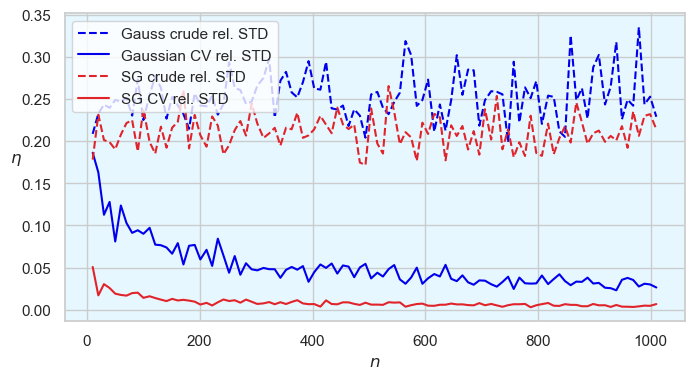

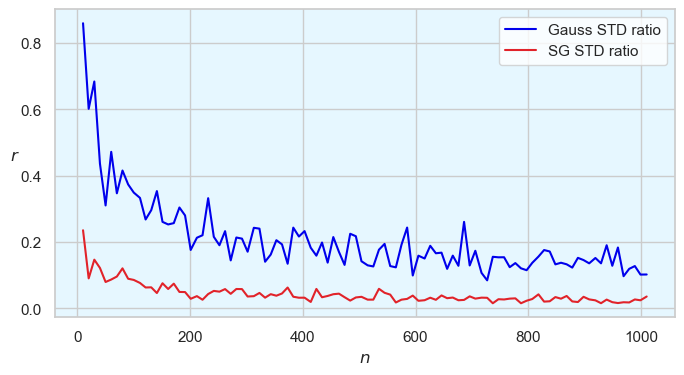

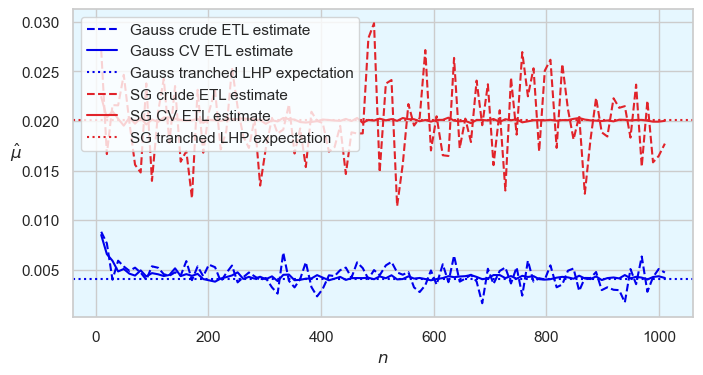

In [209]:
# Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
sns.lineplot(x = port_size_range, y = mc_ests_stds_gauss_port/mc_ests_gauss_port, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = port_size_range, y = mc_ests_stds_gauss_port * np.sqrt(1 - mc_cv_corrs_gauss_port**2) / mc_cv_ests_gauss_port, label="Gaussian CV rel. STD", color='#0000EC')

sns.lineplot(x = port_size_range, y = mc_ests_stds_sg_port/mc_ests_sg_port, label="SG crude rel. STD", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = port_size_range, y = mc_ests_stds_sg_port * np.sqrt(1 - mc_cv_corrs_sg_port**2) / mc_cv_ests_sg_port, label="SG CV rel. STD", color='#E1232A')
plt.ylabel(r"$\eta$", rotation=0)
plt.xlabel(r"$n$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = port_size_range, y = np.sqrt(1 - mc_cv_corrs_gauss_port**2), label="Gauss STD ratio", color='#0000EC')
sns.lineplot(x = port_size_range, y = np.sqrt(1 - mc_cv_corrs_sg_port**2), label="SG STD ratio", color='#E1232A')

plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$n$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = port_size_range, y = mc_ests_gauss_port, label= "Gauss crude ETL estimate", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = port_size_range, y = mc_cv_ests_gauss_port, label="Gauss CV ETL estimate", color='#0000EC')
plt.axhline(gauss_tlhp_mean_exact,label="Gauss tranched LHP expectation", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = port_size_range, y = mc_ests_sg_port, label="SG crude ETL estimate", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = port_size_range, y = mc_cv_ests_sg_port, label="SG CV ETL estimate", color='#E1232A')
plt.axhline(sg_tlhp_mean_exact,label= "SG tranched LHP expectation", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$n$")
# plt.title(fr"MC iterations = {nr_of_sims}, portfolio size = {port_size}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

### PD

In [210]:
np.random.seed(seed)
pd_range = np.linspace(0.001, 0.2, nr_of_scens) # Set range
mc_ests_gauss_PD = []
mc_ests_stds_gauss_PD = []
mc_cv_ests_gauss_PD = []
mc_cv_corrs_gauss_PD = []
tranche_lhp_exact_gauss_PD = []

mc_ests_sg_PD = []
mc_ests_stds_sg_PD = []
mc_cv_ests_sg_PD = []
mc_cv_corrs_sg_PD = []
tranche_lhp_exact_sg_PD = []

for p in pd_range:
    # Setup parameters
    pds_p = np.reshape(np.ones(port_size)*p, (1, port_size))

    #Gaussian
    gauss_lhp_mean_exact = f.tranched_lhp_expect_norm_hom(p, cor, c)
    tranche_lhp_exact_gauss_PD.append(gauss_lhp_mean_exact) 
    mc_est_gauss, mc_cv_est_gauss, est_corr_gauss, mc_est_std_gauss = f.produce_estimates_gauss_hom(nr_of_sims, port_size, pds_p, exp_weights_hom, cor, c, gauss_lhp_mean_exact)
    mc_ests_gauss_PD.append(mc_est_gauss)
    mc_ests_stds_gauss_PD.append(mc_est_std_gauss)
    mc_cv_ests_gauss_PD.append(mc_cv_est_gauss)
    mc_cv_corrs_gauss_PD.append(est_corr_gauss)

    #SG
    sg_lhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, p, cor, c, 1)
    tranche_lhp_exact_sg_PD.append(sg_lhp_mean_exact)
    mc_est_sg, mc_cv_est_sg, est_corr_sg, mc_est_std_sg = f.produce_estimates_sg_hom(nr_of_sims, port_size, a, pds_p, exp_weights_hom, cor, c, sg_lhp_mean_exact)
    mc_ests_sg_PD.append(mc_est_sg)
    mc_ests_stds_sg_PD.append(mc_est_std_sg)
    mc_cv_ests_sg_PD.append(mc_cv_est_sg)
    mc_cv_corrs_sg_PD.append(est_corr_sg)
    print(p)

mc_ests_gauss_PD = np.array(mc_ests_gauss_PD)
mc_ests_stds_gauss_PD = np.array(mc_ests_stds_gauss_PD)
mc_cv_ests_gauss_PD = np.array(mc_cv_ests_gauss_PD)
mc_cv_corrs_gauss_PD = np.array(mc_cv_corrs_gauss_PD)
tranche_lhp_exact_gauss_PD = np.array(tranche_lhp_exact_gauss_PD)
mc_ests_sg_PD = np.array(mc_ests_sg_PD)
mc_ests_stds_sg_PD = np.array(mc_ests_stds_sg_PD)
mc_cv_ests_sg_PD = np.array(mc_cv_ests_sg_PD)
mc_cv_corrs_sg_PD = np.array(mc_cv_corrs_sg_PD)
tranche_lhp_exact_sg_PD = np.array(tranche_lhp_exact_sg_PD)


0.001
0.00301010101010101
0.00502020202020202
0.00703030303030303
0.00904040404040404
0.01105050505050505
0.01306060606060606
0.015070707070707071
0.017080808080808082
0.019090909090909092
0.021101010101010103
0.023111111111111114
0.02512121212121212
0.02713131313131313
0.02914141414141414
0.031151515151515152
0.03316161616161616
0.03517171717171717
0.037181818181818184
0.039191919191919194
0.041202020202020205
0.043212121212121216
0.045222222222222226
0.04723232323232324
0.04924242424242424
0.05125252525252525
0.05326262626262626
0.05527272727272727
0.05728282828282828
0.05929292929292929
0.061303030303030304
0.06331313131313131
0.06532323232323232
0.06733333333333333
0.06934343434343435
0.07135353535353535
0.07336363636363637
0.07537373737373737
0.07738383838383839
0.07939393939393939
0.08140404040404041
0.08341414141414141
0.08542424242424243
0.08743434343434343
0.08944444444444445
0.09145454545454546
0.09346464646464647
0.09547474747474748
0.09748484848484848
0.0994949494949495
0.1

C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3799543404.py:6: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(x = pd_range, y = mc_ests_stds_gauss_PD/mc_ests_gauss_PD, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3799543404.py:7: RuntimeWarning: invalid value encountered in sqrt
  sns.lineplot(x = pd_range, y = mc_ests_stds_gauss_PD * np.sqrt(1 - mc_cv_corrs_gauss_PD**2) / mc_cv_ests_gauss_PD, label="Gaussian CV rel. STD", color='#0000EC')
C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3799543404.py:7: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(x = pd_range, y = mc_ests_stds_gauss_PD * np.sqrt(1 - mc_cv_corrs_gauss_PD**2) / mc_cv_ests_gauss_PD, label="Gaussian CV rel. STD", color='#0000EC')
C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3799543404.py:9: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(x = pd_range, y = mc_ests_stds_sg_PD/mc_e

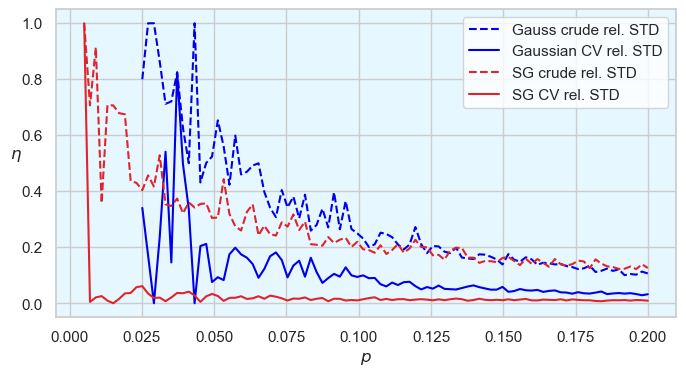

C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3799543404.py:23: RuntimeWarning: invalid value encountered in sqrt
  sns.lineplot(x = pd_range, y = np.sqrt(1 - mc_cv_corrs_gauss_PD**2), label="Gauss STD ratio", color='#0000EC')


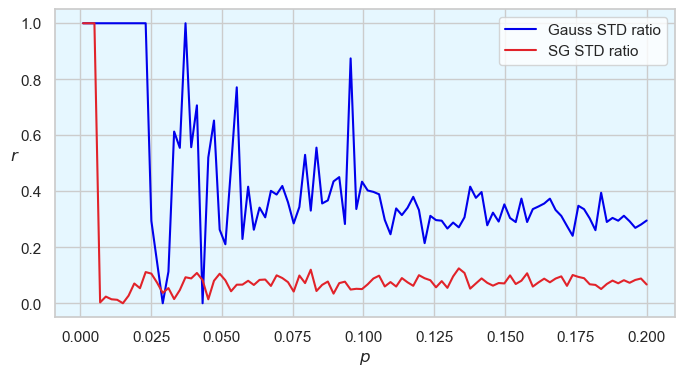

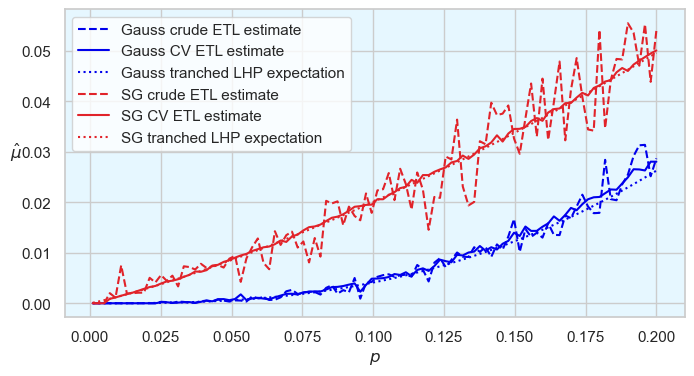

In [211]:
# Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
sns.lineplot(x = pd_range, y = mc_ests_stds_gauss_PD/mc_ests_gauss_PD, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = pd_range, y = mc_ests_stds_gauss_PD * np.sqrt(1 - mc_cv_corrs_gauss_PD**2) / mc_cv_ests_gauss_PD, label="Gaussian CV rel. STD", color='#0000EC')

sns.lineplot(x = pd_range, y = mc_ests_stds_sg_PD/mc_ests_sg_PD, label="SG crude rel. STD", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = pd_range, y = mc_ests_stds_sg_PD * np.sqrt(1 - mc_cv_corrs_sg_PD**2) / mc_cv_ests_sg_PD, label="SG CV rel. STD", color='#E1232A')
plt.ylabel(r"$\eta$", rotation=0)
plt.xlabel(r"$p$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = pd_range, y = np.sqrt(1 - mc_cv_corrs_gauss_PD**2), label="Gauss STD ratio", color='#0000EC')
sns.lineplot(x = pd_range, y = np.sqrt(1 - mc_cv_corrs_sg_PD**2), label="SG STD ratio", color='#E1232A')

plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$p$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = pd_range, y = mc_ests_gauss_PD, label= "Gauss crude ETL estimate", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = pd_range, y = mc_cv_ests_gauss_PD, label="Gauss CV ETL estimate", color='#0000EC')
sns.lineplot(x=pd_range, y=tranche_lhp_exact_gauss_PD, label="Gauss tranched LHP expectation", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = pd_range, y = mc_ests_sg_PD, label="SG crude ETL estimate", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = pd_range, y = mc_cv_ests_sg_PD, label="SG CV ETL estimate", color='#E1232A')
sns.lineplot(x=pd_range, y=tranche_lhp_exact_sg_PD, label="SG tranched LHP expectation", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$p$")
# plt.title(fr"MC iterations = {nr_of_sims}, portfolio size = {port_size}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

### Tranche Seniority

In [212]:
np.random.seed(seed)
c_range = np.linspace(0, 0.9, nr_of_scens)  # Set range

mc_ests_gauss_sen = []
mc_ests_stds_gauss_sen = []
mc_cv_ests_gauss_sen = []
mc_cv_corrs_gauss_sen = []
tranche_lhp_exact_gauss_sen = []

mc_ests_sg_sen = []
mc_ests_stds_sg_sen = []
mc_cv_ests_sg_sen = []
mc_cv_corrs_sg_sen = []
tranche_lhp_exact_sg_sen = []
for cc in c_range:

    #Gaussian
    gauss_tlhp_mean_exact = f.tranched_lhp_expect_norm_hom(pd, cor, cc)
    tranche_lhp_exact_gauss_sen.append(gauss_tlhp_mean_exact) 
    mc_est_gauss, mc_cv_est_gauss, est_corr_gauss, mc_est_std_gauss = f.produce_estimates_gauss_hom(nr_of_sims, port_size, pds, exp_weights_hom, cor, cc, gauss_tlhp_mean_exact)
    mc_ests_gauss_sen.append(mc_est_gauss)    
    mc_ests_stds_gauss_sen.append(mc_est_std_gauss)
    mc_cv_ests_gauss_sen.append(mc_cv_est_gauss)
    mc_cv_corrs_gauss_sen.append(est_corr_gauss)

    #SG
    sg_tlhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, pd, cor, cc, 1)
    tranche_lhp_exact_sg_sen.append(sg_tlhp_mean_exact)
    mc_est_sg, mc_cv_est_sg, est_corr_sg, mc_est_std_sg = f.produce_estimates_sg_hom(nr_of_sims, port_size, a, pds, exp_weights_hom, cor, cc, sg_tlhp_mean_exact)
    mc_ests_sg_sen.append(mc_est_sg)
    mc_ests_stds_sg_sen.append(mc_est_std_sg)
    mc_cv_ests_sg_sen.append(mc_cv_est_sg)
    mc_cv_corrs_sg_sen.append(est_corr_sg)
    print(cc)
mc_ests_gauss_sen = np.array(mc_ests_gauss_sen)
mc_ests_stds_gauss_sen = np.array(mc_ests_stds_gauss_sen)
mc_cv_ests_gauss_sen = np.array(mc_cv_ests_gauss_sen)
mc_cv_corrs_gauss_sen = np.array(mc_cv_corrs_gauss_sen)
tranche_lhp_exact_gauss_sen = np.array(tranche_lhp_exact_gauss_sen)

mc_ests_sg_sen = np.array(mc_ests_sg_sen)
mc_ests_stds_sg_sen = np.array(mc_ests_stds_sg_sen)
mc_cv_ests_sg_sen = np.array(mc_cv_ests_sg_sen)
mc_cv_corrs_sg_sen = np.array(mc_cv_corrs_sg_sen)
tranche_lhp_exact_sg_sen = np.array(tranche_lhp_exact_sg_sen)

0.0
0.00909090909090909
0.01818181818181818
0.02727272727272727
0.03636363636363636
0.045454545454545456
0.05454545454545454
0.06363636363636363
0.07272727272727272
0.08181818181818182
0.09090909090909091
0.09999999999999999
0.10909090909090909
0.11818181818181818
0.12727272727272726
0.13636363636363635
0.14545454545454545
0.15454545454545454
0.16363636363636364
0.17272727272727273
0.18181818181818182
0.1909090909090909
0.19999999999999998
0.20909090909090908
0.21818181818181817
0.22727272727272727
0.23636363636363636
0.24545454545454545
0.2545454545454545
0.2636363636363636
0.2727272727272727
0.2818181818181818
0.2909090909090909
0.3
0.3090909090909091
0.3181818181818182
0.32727272727272727
0.33636363636363636
0.34545454545454546
0.35454545454545455
0.36363636363636365
0.3727272727272727
0.3818181818181818
0.3909090909090909
0.39999999999999997
0.40909090909090906
0.41818181818181815
0.42727272727272725
0.43636363636363634
0.44545454545454544
0.45454545454545453
0.4636363636363636
0.4

C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\2704858690.py:6: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(x = c_range, y = mc_ests_stds_gauss_sen/mc_ests_gauss_sen, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\2704858690.py:7: RuntimeWarning: invalid value encountered in sqrt
  sns.lineplot(x = c_range, y = mc_ests_stds_gauss_sen * np.sqrt(1 - mc_cv_corrs_gauss_sen**2) / mc_cv_ests_gauss_sen, label="Gaussian CV rel. STD", color='#0000EC')
C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\2704858690.py:7: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(x = c_range, y = mc_ests_stds_gauss_sen * np.sqrt(1 - mc_cv_corrs_gauss_sen**2) / mc_cv_ests_gauss_sen, label="Gaussian CV rel. STD", color='#0000EC')


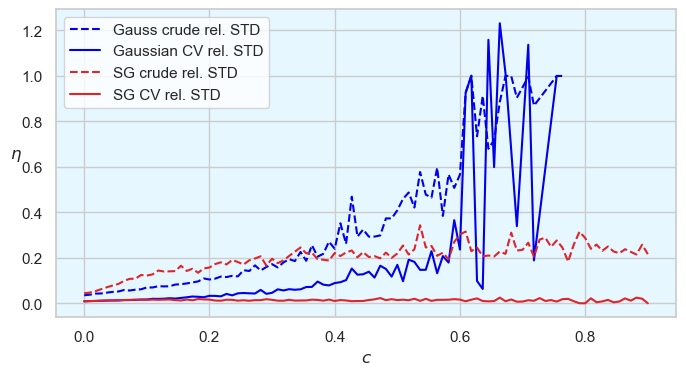

C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\2704858690.py:23: RuntimeWarning: invalid value encountered in sqrt
  sns.lineplot(x = c_range, y = np.sqrt(1 - mc_cv_corrs_gauss_sen**2), label="Gauss STD ratio", color='#0000EC')


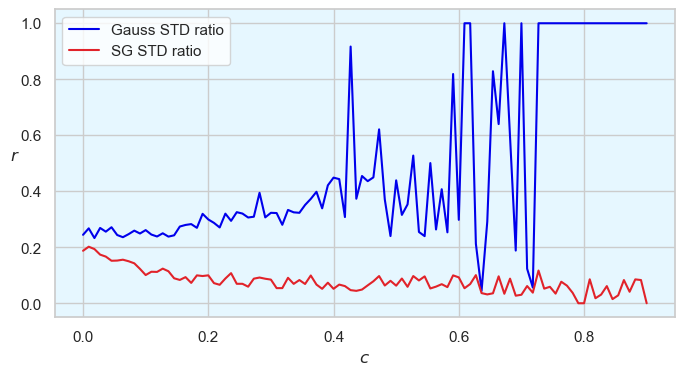

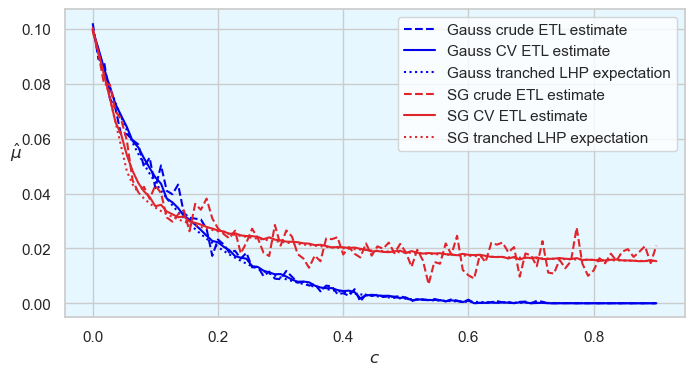

In [213]:
# Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
sns.lineplot(x = c_range, y = mc_ests_stds_gauss_sen/mc_ests_gauss_sen, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = mc_ests_stds_gauss_sen * np.sqrt(1 - mc_cv_corrs_gauss_sen**2) / mc_cv_ests_gauss_sen, label="Gaussian CV rel. STD", color='#0000EC')

sns.lineplot(x = c_range, y = mc_ests_stds_sg_sen/mc_ests_sg_sen, label="SG crude rel. STD", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = mc_ests_stds_sg_sen * np.sqrt(1 - mc_cv_corrs_sg_sen**2) / mc_cv_ests_sg_sen, label="SG CV rel. STD", color='#E1232A')
plt.ylabel(r"$\eta$", rotation=0)
plt.xlabel(r"$c$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = np.sqrt(1 - mc_cv_corrs_gauss_sen**2), label="Gauss STD ratio", color='#0000EC')
sns.lineplot(x = c_range, y = np.sqrt(1 - mc_cv_corrs_sg_sen**2), label="SG STD ratio", color='#E1232A')

plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$c$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = mc_ests_gauss_sen, label= "Gauss crude ETL estimate", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = mc_cv_ests_gauss_sen, label="Gauss CV ETL estimate", color='#0000EC')
sns.lineplot(x=c_range, y=tranche_lhp_exact_gauss_sen, label="Gauss tranched LHP expectation", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = c_range, y = mc_ests_sg_sen, label="SG crude ETL estimate", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = mc_cv_ests_sg_sen, label="SG CV ETL estimate", color='#E1232A')
sns.lineplot(x=c_range, y=tranche_lhp_exact_sg_sen, label="SG tranched LHP expectation", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$c$")
# plt.title(fr"MC iterations = {nr_of_sims}, portfolio size = {port_size}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

### Asset Correlation

In [214]:
np.random.seed(seed)
cor_range = np.linspace(0.001, 0.999, nr_of_scens)

mc_ests_gauss_cor = []
mc_ests_stds_gauss_cor = []
mc_cv_ests_gauss_cor = []
mc_cv_corrs_gauss_cor = []
tranche_lhp_exact_gauss_cor = []

mc_ests_sg_cor = []
mc_ests_stds_sg_cor = []
mc_cv_ests_sg_cor = []
mc_cv_corrs_sg_cor = []
tranche_lhp_exact_sg_cor = []

for crrltn in cor_range:

    #Gaussian
    gauss_tlhp_mean_exact = f.tranched_lhp_expect_norm_hom(pd, crrltn, c)
    tranche_lhp_exact_gauss_cor.append(gauss_tlhp_mean_exact) 
    mc_est_gauss, mc_cv_est_gauss, est_corr_gauss, mc_est_std_gauss = f.produce_estimates_gauss_hom(nr_of_sims, port_size, pds, exp_weights_hom, crrltn, c, gauss_tlhp_mean_exact)
    print(mc_est_gauss - mc_cv_est_gauss)
    mc_ests_gauss_cor.append(mc_est_gauss)
    mc_ests_stds_gauss_cor.append(mc_est_std_gauss)
    mc_cv_ests_gauss_cor.append(mc_cv_est_gauss)
    mc_cv_corrs_gauss_cor.append(est_corr_gauss)

    #SG
    sg_tlhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, pd, crrltn, c, 1)
    tranche_lhp_exact_sg_cor.append(sg_tlhp_mean_exact)
    mc_est_sg, mc_cv_est_sg, est_corr_sg, mc_est_std_sg = f.produce_estimates_sg_hom(nr_of_sims, port_size, a, pds, exp_weights_hom, crrltn, c, sg_tlhp_mean_exact)
    mc_ests_sg_cor.append(mc_est_sg)
    mc_ests_stds_sg_cor.append(mc_est_std_sg)
    mc_cv_ests_sg_cor.append(mc_cv_est_sg)
    mc_cv_corrs_sg_cor.append(est_corr_sg)
    # print(corr)
mc_ests_gauss_cor = np.array(mc_ests_gauss_cor)
mc_ests_stds_gauss_cor = np.array(mc_ests_stds_gauss_cor)
mc_cv_ests_gauss_cor = np.array(mc_cv_ests_gauss_cor)
mc_cv_corrs_gauss_cor = np.array(mc_cv_corrs_gauss_cor)

mc_ests_sg_cor = np.array(mc_ests_sg_cor)
mc_ests_stds_sg_cor = np.array(mc_ests_stds_sg_cor)
mc_cv_ests_sg_cor = np.array(mc_cv_ests_sg_cor)
mc_cv_corrs_sg_cor = np.array(mc_cv_corrs_sg_cor)
tranche_lhp_exact_sg_cor = np.array(tranche_lhp_exact_sg_cor)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.814527510745944e-05
0.0
0.0002492230727982452
4.2015077820941325e-06
5.277672898700685e-07
-5.562587112691104e-05
0.0003269753321814736
2.9309322892813005e-05
-0.00021141714160678715
-0.0005730244210268968
0.0001114677611328595
0.0006670892498968834
-0.0008103093115988114
-0.00036796253994873275
-5.359417499365034e-05
-0.0003036643784273467
0.001799793265121804
0.000298889406400485
6.628108557913152e-05
-0.0004648862019292553
0.00031007939638244726
7.062407960334305e-06
-4.4964273698440416e-06
-0.0007283953241283558
-8.897890704725239e-05
-0.00025814192855703414
-0.00188309065863548
-0.0034769104062891045
-0.0020901824387080086
0.00154759053799528
0.001366030707954347
-0.0021700262644378954
0.0013572326373903522
0.0006885386827771914
0.00031209069581709416
-0.0016463291067488964
-0.0011600354171366362
0.007205297279270072
0.004366140266610932
-0.0007059655397492273
-0.002386168748363157
-0.0015951421640288677
-0.002519701233666176
0.004024008057796

C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3376713271.py:6: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(x = cor_range, y = mc_ests_stds_gauss_cor/mc_ests_gauss_cor, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3376713271.py:7: RuntimeWarning: invalid value encountered in sqrt
  sns.lineplot(x = cor_range, y = mc_ests_stds_gauss_cor * np.sqrt(1 - mc_cv_corrs_gauss_cor**2) / mc_cv_ests_gauss_cor, label="Gaussian CV rel. STD", color='#0000EC')
C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3376713271.py:7: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(x = cor_range, y = mc_ests_stds_gauss_cor * np.sqrt(1 - mc_cv_corrs_gauss_cor**2) / mc_cv_ests_gauss_cor, label="Gaussian CV rel. STD", color='#0000EC')
C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3376713271.py:9: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(x = cor_range, y = mc_ests_std

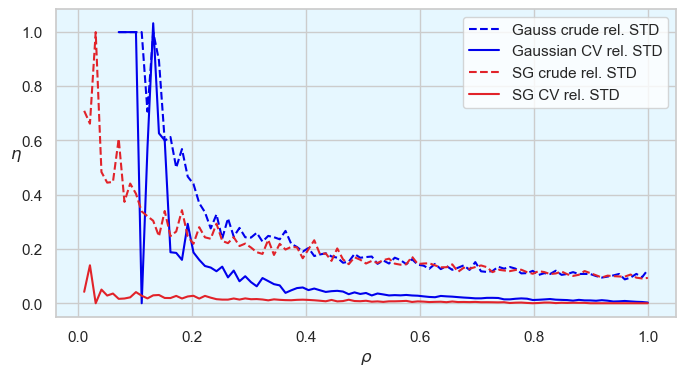

C:\Users\cnlve\AppData\Local\Temp\ipykernel_13832\3376713271.py:23: RuntimeWarning: invalid value encountered in sqrt
  sns.lineplot(x = cor_range, y = np.sqrt(1 - mc_cv_corrs_gauss_cor**2), label="Gauss STD ratio", color='#0000EC')


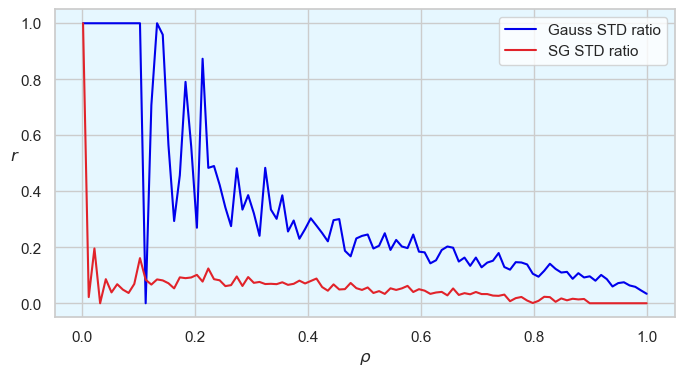

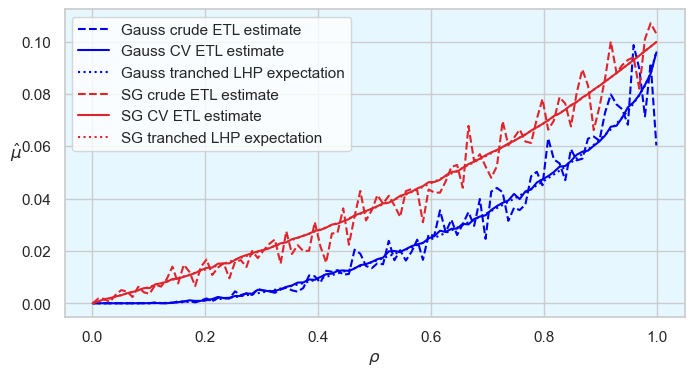

In [215]:
# Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
sns.lineplot(x = cor_range, y = mc_ests_stds_gauss_cor/mc_ests_gauss_cor, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = cor_range, y = mc_ests_stds_gauss_cor * np.sqrt(1 - mc_cv_corrs_gauss_cor**2) / mc_cv_ests_gauss_cor, label="Gaussian CV rel. STD", color='#0000EC')

sns.lineplot(x = cor_range, y = mc_ests_stds_sg_cor/mc_ests_sg_cor, label="SG crude rel. STD", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = cor_range, y = mc_ests_stds_sg_cor * np.sqrt(1 - mc_cv_corrs_sg_cor**2) / mc_cv_ests_sg_cor, label="SG CV rel. STD", color='#E1232A')
plt.ylabel(r"$\eta$", rotation=0)
plt.xlabel(r"$\rho$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = cor_range, y = np.sqrt(1 - mc_cv_corrs_gauss_cor**2), label="Gauss STD ratio", color='#0000EC')
sns.lineplot(x = cor_range, y = np.sqrt(1 - mc_cv_corrs_sg_cor**2), label="SG STD ratio", color='#E1232A')

plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$\rho$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = cor_range, y = mc_ests_gauss_cor, label= "Gauss crude ETL estimate", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = cor_range, y = mc_cv_ests_gauss_cor, label="Gauss CV ETL estimate", color='#0000EC')
sns.lineplot(x=cor_range, y=tranche_lhp_exact_gauss_cor, label="Gauss tranched LHP expectation", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = cor_range, y = mc_ests_sg_cor, label="SG crude ETL estimate", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = cor_range, y = mc_cv_ests_sg_cor, label="SG CV ETL estimate", color='#E1232A')
sns.lineplot(x=cor_range, y=tranche_lhp_exact_sg_cor, label="SG tranched LHP expectation", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$\rho$")
# plt.title(fr"MC iterations = {nr_of_sims}, portfolio size = {port_size}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

## Inhomogenous Portfolio Analysis

### Portfolio 1: Two Homogenous Groups 

In [216]:
np.random.seed(seed)
nr_of_sims = 100000
port_size = 100
a=1
exposures = np.concatenate([np.ones(int(port_size/2)), np.ones(int(port_size/2))*0.02])
exp_weights = exposures / exposures.sum()
pds = np.reshape(np.concatenate([np.ones(int(port_size/2))*0.01, np.ones(int(port_size/2))*0.5]), (1, port_size))
pd_mean = np.inner(pds, exp_weights)[0]
cor = 0.3
d = 1
xd = -np.infty

In [217]:
np.random.seed(seed)
c_range = np.linspace(0.01, 0.4, 100)

crude_ests_gauss_p1 = []
crude_stds_gauss_p1 = []
cv_inhom_ests_gauss_p1 = []
cv_hom_ests_gauss_p1 = []
corrs_inhom_gauss_p1 = []
corrs_hom_gauss_p1 = []
exact_inhom_exp_gauss_p1 = []
exact_hom_exp_gauss_p1 = []
attachment_points_gauss_p1 = []

crude_ests_sg_p1 = []
crude_stds_sg_p1 = []
cv_inhom_ests_sg_p1 = []
cv_hom_ests_sg_p1 = []
corrs_inhom_sg_p1 = []
corrs_hom_sg_p1 = []
exact_inhom_exp_sg_p1 = []
exact_hom_exp_sg_p1 = []
attachment_points_sg_p1 = []

print("Simulating Gaussian Model...")
for c in c_range:
    print(c)
    gauss_func = lambda x: f.cond_el_norm_inhom(x, pds, exp_weights, cor)-c
    xc = fsolve(gauss_func, 0)[0]
    oa_quantities = f.produce_estimates_gauss_inhom(nr_of_sims, port_size, pds, exp_weights, cor, c, d, xc, xd)
    tranche_losses = oa_quantities[0]
    cv_adjusted_tranche_losses_inhom = oa_quantities[1]
    cv_adjusted_tranche_losses_hom = oa_quantities[2]
    est_corr_inhom = oa_quantities[3]
    est_corr_hom = oa_quantities[4]
    exact_exp_inhom = oa_quantities[5]
    exact_exp_hom = oa_quantities[6]
    crude_ests_gauss_p1.append(tranche_losses.mean())
    crude_stds_gauss_p1.append(tranche_losses.std()/np.sqrt(nr_of_sims))
    cv_inhom_ests_gauss_p1.append(cv_adjusted_tranche_losses_inhom.mean())
    cv_hom_ests_gauss_p1.append(cv_adjusted_tranche_losses_hom.mean())
    corrs_inhom_gauss_p1.append(est_corr_inhom)
    corrs_hom_gauss_p1.append(est_corr_hom)
    exact_inhom_exp_gauss_p1.append(exact_exp_inhom)
    exact_hom_exp_gauss_p1.append(exact_exp_hom)
    attachment_points_gauss_p1.append(c)

print("Simulating shifted gamma Model")
for c in c_range:
    print(c)
    sg_func = lambda x: f.cond_pd_sg_inhom(x, a, pds, exp_weights, cor)-c
    xc  = fsolve(sg_func, 0)[0]
    oa_quantities = f.produce_estimates_sg_inhom(nr_of_sims, port_size, a, pds, exp_weights, cor, c, d, xc, xd)
    tranche_losses = oa_quantities[0]
    cv_adjusted_tranche_losses_inhom = oa_quantities[1]
    cv_adjusted_tranche_losses_hom = oa_quantities[2]
    est_corr_inhom = oa_quantities[3]
    est_corr_hom = oa_quantities[4]
    lhp_tranche_losses_exact_mean_inhom = oa_quantities[5]
    lhp_tranche_losses_exact_mean_hom = oa_quantities[6]
    crude_ests_sg_p1.append(tranche_losses.mean())
    crude_stds_sg_p1.append(tranche_losses.std()/np.sqrt(nr_of_sims))
    cv_inhom_ests_sg_p1.append(cv_adjusted_tranche_losses_inhom.mean())
    cv_hom_ests_sg_p1.append(cv_adjusted_tranche_losses_hom.mean())
    corrs_inhom_sg_p1.append(est_corr_inhom)
    corrs_hom_sg_p1.append(est_corr_hom)
    exact_inhom_exp_sg_p1.append(lhp_tranche_losses_exact_mean_inhom)
    exact_hom_exp_sg_p1.append(lhp_tranche_losses_exact_mean_hom)
    attachment_points_sg_p1.append(c)

crude_ests_gauss_p1 = np.array(crude_ests_gauss_p1)
crude_stds_gauss_p1 = np.array(crude_stds_gauss_p1)
cv_inhom_ests_gauss_p1 = np.array(cv_inhom_ests_gauss_p1)
cv_hom_ests_gauss_p1 = np.array(cv_hom_ests_gauss_p1)
corrs_inhom_gauss_p1 = np.array(corrs_inhom_gauss_p1)
corrs_hom_gauss_p1 = np.array(corrs_hom_gauss_p1)
exact_inhom_exp_gauss_p1 = np.array(exact_inhom_exp_gauss_p1)
exact_hom_exp_gauss_p1 = np.array(exact_hom_exp_gauss_p1)
attachment_points_gauss_p1 = np.array(attachment_points_gauss_p1)

crude_ests_sg_p1 = np.array(crude_ests_sg_p1)
crude_stds_sg_p1 = np.array(crude_stds_sg_p1)
cv_inhom_ests_sg_p1 = np.array(cv_inhom_ests_sg_p1)
cv_hom_ests_sg_p1 = np.array(cv_hom_ests_sg_p1)
corrs_inhom_sg_p1 = np.array(corrs_inhom_sg_p1)
corrs_hom_sg_p1 = np.array(corrs_hom_sg_p1)
exact_inhom_exp_sg_p1 = np.array(exact_inhom_exp_sg_p1)
exact_hom_exp_sg_p1 = np.array(exact_hom_exp_sg_p1)
attachment_points_sg_p1 = np.array(attachment_points_sg_p1)

Simulating Gaussian Model...
0.01
0.013939393939393939
0.01787878787878788
0.02181818181818182
0.025757575757575757
0.0296969696969697
0.03363636363636364
0.037575757575757575
0.04151515151515152
0.045454545454545456
0.0493939393939394
0.05333333333333334
0.057272727272727274
0.06121212121212122
0.06515151515151515
0.06909090909090909
0.07303030303030303
0.07696969696969697
0.0809090909090909
0.08484848484848485
0.08878787878787879
0.09272727272727273
0.09666666666666666
0.1006060606060606
0.10454545454545454
0.10848484848484849
0.11242424242424243
0.11636363636363636
0.1203030303030303
0.12424242424242424
0.1281818181818182
0.13212121212121214
0.13606060606060608
0.14
0.14393939393939395
0.1478787878787879
0.15181818181818182
0.15575757575757576
0.15969696969696973
0.16363636363636366
0.1675757575757576
0.17151515151515154
0.17545454545454547
0.1793939393939394
0.18333333333333335
0.18727272727272729
0.19121212121212122
0.19515151515151516
0.1990909090909091
0.20303030303030306
0.2069

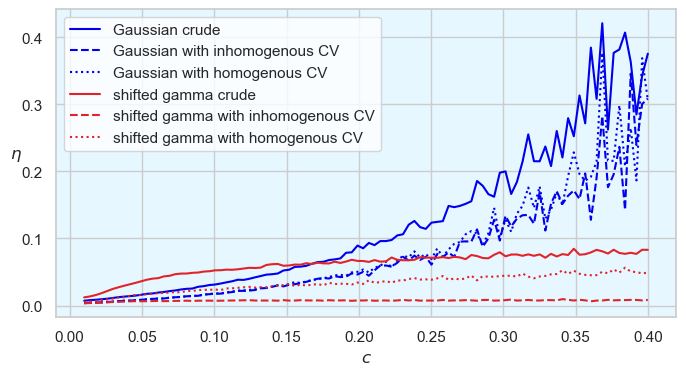

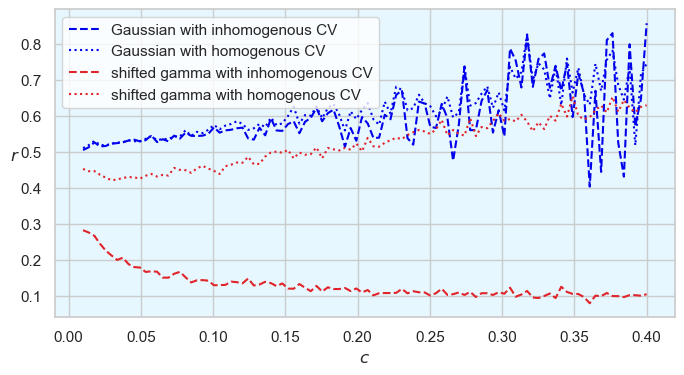

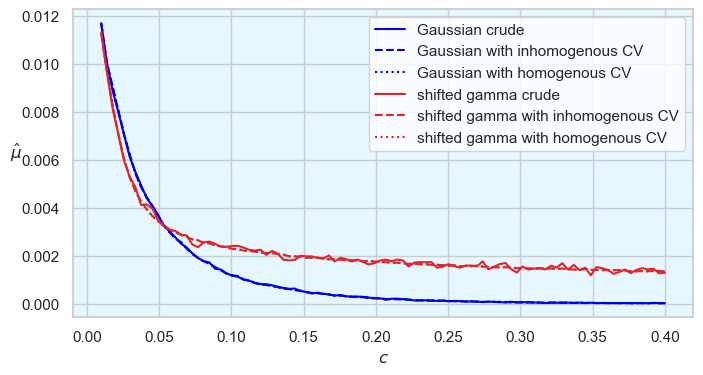

In [218]:
# Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = crude_stds_gauss_p1/crude_ests_gauss_p1, label="Gaussian crude", color='#0000EC')
sns.lineplot(x = c_range, y = crude_stds_gauss_p1 * np.sqrt(1 - corrs_inhom_gauss_p1**2) / cv_inhom_ests_gauss_p1, label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = crude_stds_gauss_p1 * np.sqrt(1 - corrs_hom_gauss_p1**2) / cv_hom_ests_gauss_p1, label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")

sns.lineplot(x = c_range, y = crude_stds_sg_p1/crude_ests_sg_p1, label="shifted gamma crude", color='#E1232A')
sns.lineplot(x = c_range, y = crude_stds_sg_p1 * np.sqrt(1 - corrs_inhom_sg_p1**2) / cv_inhom_ests_sg_p1, label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = crude_stds_sg_p1 * np.sqrt(1 - corrs_hom_sg_p1**2) / cv_hom_ests_sg_p1, label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")

# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.xlabel(r"$c$")
plt.ylabel(r"$\eta$",rotation=0)
plt.legend()
plt.show()

# STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_inhom_gauss_p1**2), label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_hom_gauss_p1**2), label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")

sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_inhom_sg_p1**2), label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_hom_sg_p1**2), label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")

plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$c$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = crude_ests_gauss_p1, label= "Gaussian crude", color='#0000EC')
sns.lineplot(x = c_range, y = cv_inhom_ests_gauss_p1, label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = cv_hom_ests_gauss_p1, label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")

sns.lineplot(x = c_range, y = crude_ests_sg_p1, label= "shifted gamma crude", color='#E1232A')
sns.lineplot(x = c_range, y = cv_inhom_ests_sg_p1, label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = cv_inhom_ests_sg_p1, label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")

plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$c$")
plt.legend()
plt.show()

### Portfolio 2: Uniform exposures and PDs

In [219]:
np.random.seed(seed)
nr_of_sims = 100000
port_size = 100
a=1
exposures = np.random.uniform(0,1,port_size)
exp_weights = exposures / np.sum(exposures)
pds = np.random.uniform(0, 0.2, (1, port_size))
pd_mean = np.inner(pds, exp_weights)[0]
cor = 0.3
d = 1
xd = -np.infty

In [220]:
np.random.seed(seed)
c_range = np.linspace(0.01, 0.4, 100)

crude_ests_gauss_p2 = []
crude_stds_gauss_p2 = []
cv_inhom_ests_gauss_p2 = []
cv_hom_ests_gauss_p2 = []
corrs_inhom_gauss_p2 = []
corrs_hom_gauss_p2 = []
exact_inhom_exp_gauss_p2 = []
exact_hom_exp_gauss_p2 = []
attachment_points_gauss_p2 = []

crude_ests_sg_p2 = []
crude_stds_sg_p2 = []
cv_inhom_ests_sg_p2 = []
cv_hom_ests_sg_p2 = []
corrs_inhom_sg_p2 = []
corrs_hom_sg_p2 = []
exact_inhom_exp_sg_p2 = []
exact_hom_exp_sg_p2 = []
attachment_points_sg_p2 = []

print("Simulating Gaussian Model...")
for c in c_range:
    print(c)
    gauss_func = lambda x: f.cond_el_norm_inhom(x, pds, exp_weights, cor)-c
    xc = fsolve(gauss_func, 0)[0]
    oa_quantities = f.produce_estimates_gauss_inhom(nr_of_sims, port_size, pds, exp_weights, cor, c, d, xc, xd)
    tranche_losses = oa_quantities[0]
    cv_adjusted_tranche_losses_inhom = oa_quantities[1]
    cv_adjusted_tranche_losses_hom = oa_quantities[2]
    est_corr_inhom = oa_quantities[3]
    est_corr_hom = oa_quantities[4]
    exact_exp_inhom = oa_quantities[5]
    exact_exp_hom = oa_quantities[6]
    crude_ests_gauss_p2.append(tranche_losses.mean())
    crude_stds_gauss_p2.append(tranche_losses.std()/np.sqrt(nr_of_sims))
    cv_inhom_ests_gauss_p2.append(cv_adjusted_tranche_losses_inhom.mean())
    cv_hom_ests_gauss_p2.append(cv_adjusted_tranche_losses_hom.mean())
    corrs_inhom_gauss_p2.append(est_corr_inhom)
    corrs_hom_gauss_p2.append(est_corr_hom)
    exact_inhom_exp_gauss_p2.append(exact_exp_inhom)
    exact_hom_exp_gauss_p2.append(exact_exp_hom)
    attachment_points_gauss_p2.append(c)

print("Simulating shifted gamma Model")
for c in c_range:
    print(c)
    sg_func = lambda x: f.cond_pd_sg_inhom(x, a, pds, exp_weights, cor)-c
    xc  = fsolve(sg_func, 0)[0]
    oa_quantities = f.produce_estimates_sg_inhom(nr_of_sims, port_size, a, pds, exp_weights, cor, c, d, xc, xd)
    tranche_losses = oa_quantities[0]
    cv_adjusted_tranche_losses_inhom = oa_quantities[1]
    cv_adjusted_tranche_losses_hom = oa_quantities[2]
    est_corr_inhom = oa_quantities[3]
    est_corr_hom = oa_quantities[4]
    lhp_tranche_losses_exact_mean_inhom = oa_quantities[5]
    lhp_tranche_losses_exact_mean_hom = oa_quantities[6]
    crude_ests_sg_p2.append(tranche_losses.mean())
    crude_stds_sg_p2.append(tranche_losses.std()/np.sqrt(nr_of_sims))
    cv_inhom_ests_sg_p2.append(cv_adjusted_tranche_losses_inhom.mean())
    cv_hom_ests_sg_p2.append(cv_adjusted_tranche_losses_hom.mean())
    corrs_inhom_sg_p2.append(est_corr_inhom)
    corrs_hom_sg_p2.append(est_corr_hom)
    exact_inhom_exp_sg_p2.append(lhp_tranche_losses_exact_mean_inhom)
    exact_hom_exp_sg_p2.append(lhp_tranche_losses_exact_mean_hom)
    attachment_points_sg_p2.append(c)

crude_ests_gauss_p2 = np.array(crude_ests_gauss_p2)
crude_stds_gauss_p2 = np.array(crude_stds_gauss_p2)
cv_inhom_ests_gauss_p2 = np.array(cv_inhom_ests_gauss_p2)
cv_hom_ests_gauss_p2 = np.array(cv_hom_ests_gauss_p2)
corrs_inhom_gauss_p2 = np.array(corrs_inhom_gauss_p2)
corrs_hom_gauss_p2 = np.array(corrs_hom_gauss_p2)
exact_inhom_exp_gauss_p2 = np.array(exact_inhom_exp_gauss_p2)
exact_hom_exp_gauss_p2 = np.array(exact_hom_exp_gauss_p2)
attachment_points_gauss_p2 = np.array(attachment_points_gauss_p2)

crude_ests_sg_p2 = np.array(crude_ests_sg_p2)
crude_stds_sg_p2 = np.array(crude_stds_sg_p2)
cv_inhom_ests_sg_p2 = np.array(cv_inhom_ests_sg_p2)
cv_hom_ests_sg_p2 = np.array(cv_hom_ests_sg_p2)
corrs_inhom_sg_p2 = np.array(corrs_inhom_sg_p2)
corrs_hom_sg_p2 = np.array(corrs_hom_sg_p2)
exact_inhom_exp_sg_p2 = np.array(exact_inhom_exp_sg_p2)
exact_hom_exp_sg_p2 = np.array(exact_hom_exp_sg_p2)
attachment_points_sg_p2 = np.array(attachment_points_sg_p2)

Simulating Gaussian Model...
0.01
0.013939393939393939
0.01787878787878788
0.02181818181818182
0.025757575757575757
0.0296969696969697
0.03363636363636364
0.037575757575757575
0.04151515151515152
0.045454545454545456
0.0493939393939394
0.05333333333333334
0.057272727272727274
0.06121212121212122
0.06515151515151515
0.06909090909090909
0.07303030303030303
0.07696969696969697
0.0809090909090909
0.08484848484848485
0.08878787878787879
0.09272727272727273
0.09666666666666666
0.1006060606060606
0.10454545454545454
0.10848484848484849
0.11242424242424243
0.11636363636363636
0.1203030303030303
0.12424242424242424
0.1281818181818182
0.13212121212121214
0.13606060606060608
0.14
0.14393939393939395
0.1478787878787879
0.15181818181818182
0.15575757575757576


KeyboardInterrupt: 

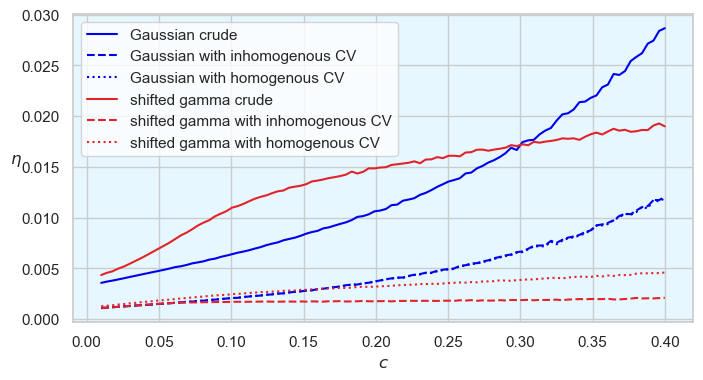

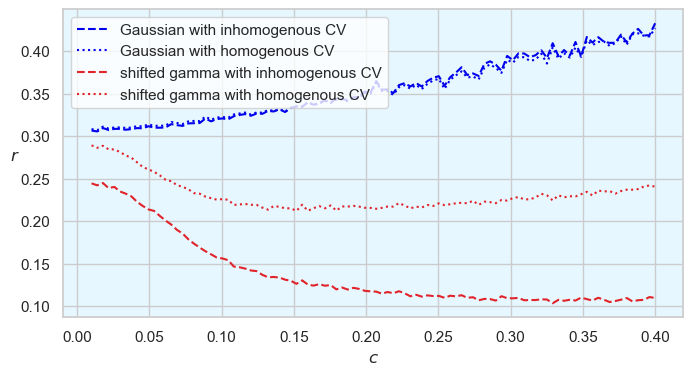

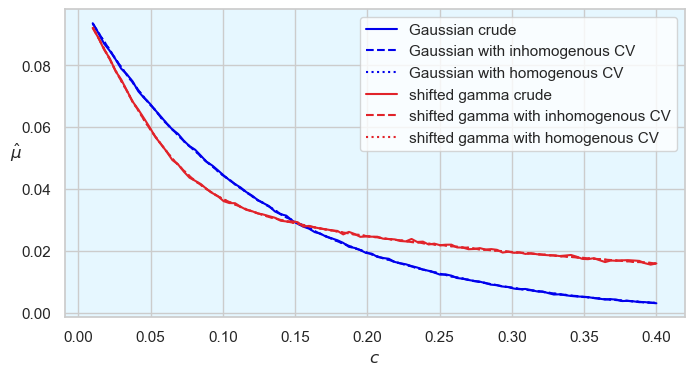

In [ ]:
# Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = crude_stds_gauss_p2/crude_ests_gauss_p2, label="Gaussian crude", color='#0000EC')
sns.lineplot(x = c_range, y = crude_stds_gauss_p2 * np.sqrt(1 - corrs_inhom_gauss_p2**2) / cv_inhom_ests_gauss_p2, label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = crude_stds_gauss_p2 * np.sqrt(1 - corrs_hom_gauss_p2**2) / cv_hom_ests_gauss_p2, label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")

sns.lineplot(x = c_range, y = crude_stds_sg_p2/crude_ests_sg_p2, label="shifted gamma crude", color='#E1232A')
sns.lineplot(x = c_range, y = crude_stds_sg_p2 * np.sqrt(1 - corrs_inhom_sg_p2**2) / cv_inhom_ests_sg_p2, label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = crude_stds_sg_p2 * np.sqrt(1 - corrs_hom_sg_p2**2) / cv_hom_ests_sg_p2, label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")

# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.xlabel(r"$c$")
plt.ylabel(r"$\eta$",rotation=0)
plt.legend()
plt.show()

# STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_inhom_gauss_p2**2), label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_hom_gauss_p2**2), label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")

sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_inhom_sg_p2**2), label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_hom_sg_p2**2), label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")

plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$c$")
# plt.title(fr"MC iterations = {nr_of_sims}, PD = {pd}, asset correlation = {cor}, tranche = {(c,1)}")
plt.legend()
plt.show()

# ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = crude_ests_gauss_p2, label= "Gaussian crude", color='#0000EC')
sns.lineplot(x = c_range, y = cv_inhom_ests_gauss_p2, label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = cv_hom_ests_gauss_p2, label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")

sns.lineplot(x = c_range, y = crude_ests_sg_p2, label= "shifted gamma crude", color='#E1232A')
sns.lineplot(x = c_range, y = cv_inhom_ests_sg_p2, label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = cv_inhom_ests_sg_p2, label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")

plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$c$")
plt.legend()
plt.show()